In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, simps
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## Notes

__From rotmod.c:__ <br>
For the  sampling radii you should use an increment of about 0.2 times the disk scale length, and the maximum sampling radius should at least be larger than the radius of the last measured point on your observed rotation curve. <br>
If the user wants to enter a measured density profile, and the central density is not given (density at R=0), the program will use linear extrapolation to obtain the central density.

## User input

In [2]:
user = True  # use imported data

# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
#raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
#raddens = "../data/nord-mu.txt"
#units = 'KPC,MSUN/PC**2'

# Disk:
# See for more: grav_project/NGC_5005/Disk_from_surface_brightness_profile.ipynb
raddens = "../data/NGC5005-disk_arcsec.txt"    # Disk surface brightness with 4 colums, units: ARCSEC, MAG/ARCSEC^2
units = 'ARCSEC,MAG/ARCSEC**2'

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
z0 = 0.93
distance = 16.5                     # Distance in MPC
h = 5                             # GUESS: radial scale-length (KPC)

# Smoothing parameters
windowsize = 13
polynomial_order = 4
degree = 3

## Density profile

In [3]:
def DensityProfile(user=user,raddens=raddens,units=units,h=h):
    
    if units == 'KPC,MSUN/PC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T

    if units == 'ARCSEC,MAG/ARCSEC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T

        # Conversion
        # ARCSEC to KPC
        xdinp = (np.pi/648000) * distance * 1e3 * xdinp

        # MAG/ARCSEC^2 to MSUN/PC^2
        ydinp = 10**(-0.4 * ydinp)
        ydinp = ((np.pi/648000) * distance * 1e6)**(-2) * ydinp
            
    if units == 'KPC,MAG/ARCSEC**2':
        mudata = np.loadtxt(raddens)
        if np.shape(np.loadtxt(raddens))[1] == 2:
            xdinp, ydinp = mudata.T
        if np.shape(np.loadtxt(raddens))[1] == 4:
            xdinp, ydinp, xerror, yerror = mudata.T

        # Conversion
        # MAG/ARCSEC^2 to MSUN/PC^2
        ydinp = 10**(-0.4 * ydinp)
        ydinp = ((np.pi/648000) * distance * 1e6)**(-2) * ydinp
            
    LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
    LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
    ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
    rcut = xdinp[ndinp-1]               # takes second to last radius value
    delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    return xdinp, ydinp, rcut, delta

## Define some values

In [4]:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]

# Cutoff radius
rcut = DensityProfile()[2]
# Cutoff length
delta = DensityProfile()[3]

# Sampling radii
radii = np.arange(0.38,np.max(xdinp)+1,0.2*h)               # Sampling radii
#radii = np.arange(0.3,np.max(xdinp)+1,0.2*h)               # Sampling radii
# Note from rotmod.c: 
# For the sampling radii you should use an increment of about 0.2 times the disk scale length, 
# and the maximum sampling radius should at least be larger than the radius of the last measured point 
# on your observed rotation curve. 

In [5]:
print(xdinp[0])
print(xdinp)
print(radii)

0.16757996979180054
[ 0.16757997  0.3245447   0.5056597   0.80466224  1.09128966  1.42536968
  1.74770654  2.0936177   2.40404342  2.97747425  3.59863766  4.21907312
  4.80369515  5.3643909   6.00852866  6.5929747   7.18957188  7.21349816
  7.77446589  8.3830702   8.97957138  9.58831168 10.22080227 10.79373714
 11.40219746 12.01090576 12.60758293 13.2042281  13.76496384 14.40923759
 15.29204622 16.21048428 17.08114978 17.99953185 18.89389965 19.78845143
 20.68304321 21.57727501 22.49561709 23.36618659 24.29649581 25.19067961
 26.10870171 26.96726408 27.88543016 28.76768683 29.68576492 30.58030071
 31.4983308  32.38041948 33.28643444 34.18075424 35.08699318 35.94546755]
[ 0.38  1.38  2.38  3.38  4.38  5.38  6.38  7.38  8.38  9.38 10.38 11.38
 12.38 13.38 14.38 15.38 16.38 17.38 18.38 19.38 20.38 21.38 22.38 23.38
 24.38 25.38 26.38 27.38 28.38 29.38 30.38 31.38 32.38 33.38 34.38 35.38
 36.38]


## Interpolation

In [6]:
# Define interpolation function
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=degree)   

# Spline the given radius and density pairs and define the polynomial that's calculated
spline_rhor = interpd(xdinp,ydinp)

In [7]:
# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
smooth_rhor = savgol_filter(spline_rhor(radii), windowsize, polynomial_order)  # window size 11, polynomial order 5
# Interpolate smoothed density
#spline_smooth_rhor = interpd(radii,spline_rhor(radii))
spline_smooth_rhor = interpd(radii,smooth_rhor)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


2.2412623936301497e-10
5.917283512053767e-10


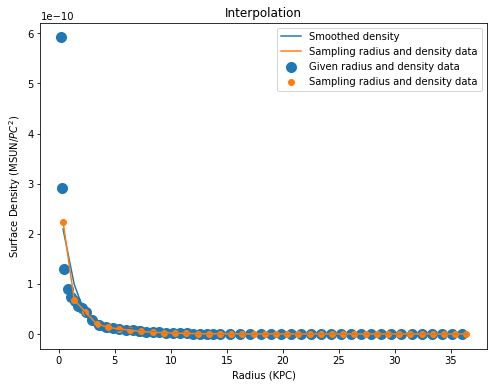

In [8]:
# Just for plotting: evaluate density values at the sampling radii 
density = spline_rhor(radii)
print(density[0])
print(ydinp[0])

# Plot 
plt.figure(figsize=(8,6))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,density, label="Sampling radius and density data")
plt.plot(radii,smooth_rhor, label="Smoothed density")
plt.plot(radii,density, label="Sampling radius and density data")
plt.title("Interpolation")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Partial derivative / Smoothing

In [9]:
# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
#drho_du = spline_rhor.derivative()
drho_du = spline_smooth_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, windowsize, polynomial_order)  # window size 11, polynomial order 5

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


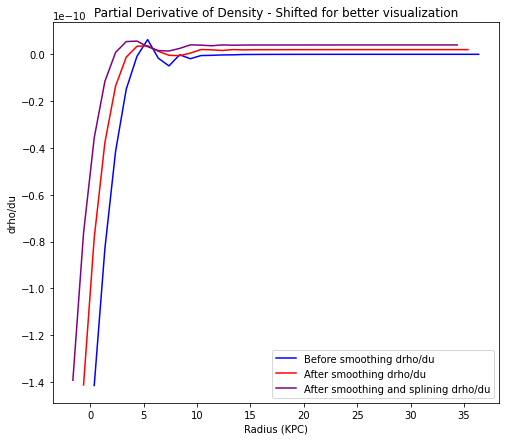

In [10]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii-1,drho_du_smooth+2e-12, label="After smoothing drho/du", c="red")
plt.plot(radii-2,spline_drhor(radii)+4e-12, label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density - Shifted for better visualization")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [11]:
# Density Distribution: Sech-squared law
def denzed(z,z0): 
    r = np.cosh(z / z0)
    #r = r * r * z0    # In the GIPSY rotmod.c, this is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    r = r * r
    r = 1.0 / r
    return r           # calling this r is kind of misleading but Rotmod is calling it r
                       # returns: density as a function of z (I think)

In [12]:
# Casertano Eq 2
def drho_du(u,z,z0):
    return spline_drhor(u) * denzed(z,z0)

print(drho_du(1,1,z0))

-3.787057013650413e-11


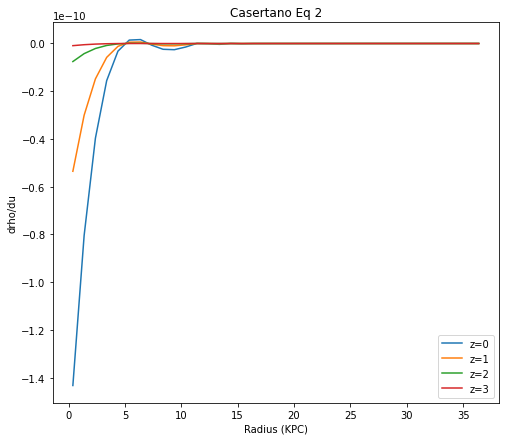

In [13]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du(radii,0,z0), label="z=0")
plt.plot(radii,drho_du(radii,1,z0), label="z=1")
plt.plot(radii,drho_du(radii,2,z0), label="z=2")
plt.plot(radii,drho_du(radii,3,z0), label="z=3")
plt.title("Casertano Eq 2")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

In [14]:
# Casertano Eq 5
def px(r,u,xi):
    x = (r**2 + u**2 + xi**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

print(px(1,1,1))

0.3819660112501051


In [15]:
# Complete elliptic integral
def K(r,u,xi):
    elliptical = (2/(np.pi*np.sqrt(r*u*px(r,u,xi)))) * (ellipk(px(r,u,xi)) - ellipe(px(r,u,xi)))
    return elliptical

print(K(1,1,1))

0.3680901991747202


In [16]:
# Integrand, using built-in functions
def integrand(r,u,z,z0,G):
    return (4 * np.pi * G) * u * K(r,u,z) * drho_du(u,z,z0)
    
print(integrand(3,2,1,z0,G))

-4.421306454869979e-16


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


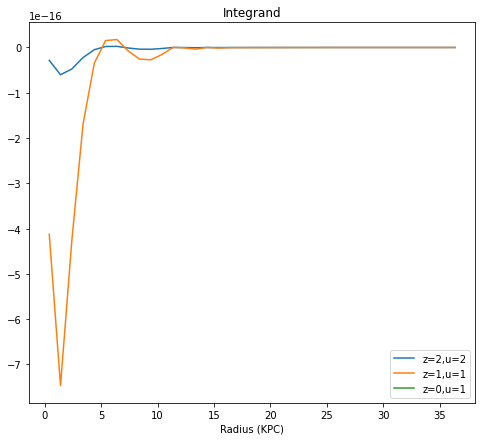

In [17]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,integrand(2,radii,2,z0,G), label="z=2,u=2")
plt.plot(radii,integrand(1,radii,1,z0,G), label="z=1,u=1")
plt.plot(radii,integrand(0,radii,1,z0,G), label="z=0,u=1")
plt.title("Integrand")
plt.xlabel("Radius (KPC)")
plt.legend()
plt.show()

## Integration

In [18]:
# Define minimum and maximum values of radius for integration
intmin = 0.01 #np.min(radii)
intmax = np.max(radii)

print(intmin)
print(intmax)
#intmax = np.inf
#intmax = rcut+delta

0.01
36.379999999999995


### Integration, using built-in python functions: scipy quad

In [19]:
# Reverse order of variables to setup for integration
integrand_mixvar = lambda z,r,u,z0,G: integrand(r,u,z,z0,G)

# Inner integral, integral over z
integrand2 = lambda r,u,z0,G: quad(integrand_mixvar, intmin, intmax, args=(r,u,z0,G))[0]
print(integrand2(2,1,z0,G))

# Reverse order of variables to setup for integration
integrand_mixvar2 = lambda u,r,z0,G: integrand2(r,u,z0,G)

# Outer integral, integral over u
radialforce = lambda r,z0,G: quad(integrand_mixvar2, intmin, intmax, args=(r,z0,G))[0]

# Calculate radial force
radialforce = np.vectorize(radialforce)
print(radialforce(radii,z0,G))

-1.4441757092198498e-15
[-5.39009991e-15 -5.18653085e-15 -4.15593841e-15 -3.17133362e-15
 -2.40614403e-15 -1.88529384e-15 -1.58144566e-15 -1.44846285e-15
 -1.33714309e-15 -1.23788223e-15 -1.11210466e-15 -9.77655537e-16
 -8.82988564e-16 -8.09791375e-16 -7.43358091e-16 -6.89231766e-16
 -6.41257404e-16 -5.99672636e-16 -5.63503966e-16 -5.31573073e-16
 -5.02947290e-16 -4.77256865e-16 -4.54080613e-16 -4.33053334e-16
 -4.13813927e-16 -3.96235894e-16 -3.80134834e-16 -3.65331307e-16
 -3.51606062e-16 -3.38878198e-16 -3.27051645e-16 -3.16022503e-16
 -3.05704130e-16 -2.96034608e-16 -2.86970105e-16 -2.78442252e-16
 -2.70384706e-16]


## Velocity

In [20]:
velocs = np.sqrt(-radii*radialforce(radii,z0,G))
print(velocs)

velocs_smooth = savgol_filter(velocs[np.isnan(velocs) == False], 7, 5)
print(velocs_smooth)

[4.52574631e-08 8.46014927e-08 9.94541774e-08 1.03533123e-07
 1.02659198e-07 1.00711871e-07 1.00447117e-07 1.03390792e-07
 1.05854896e-07 1.07755906e-07 1.07441362e-07 1.05478529e-07
 1.04553328e-07 1.04091347e-07 1.03389987e-07 1.02958169e-07
 1.02488030e-07 1.02089717e-07 1.01770344e-07 1.01498208e-07
 1.01242608e-07 1.01013622e-07 1.00808353e-07 1.00622000e-07
 1.00442937e-07 1.00281937e-07 1.00139687e-07 1.00013855e-07
 9.98928427e-08 9.97809674e-08 9.96786284e-08 9.95830616e-08
 9.94922094e-08 9.94064143e-08 9.93279025e-08 9.92536493e-08
 9.91796128e-08]
[4.52630231e-08 8.45681327e-08 9.95375775e-08 1.03421923e-07
 1.02639186e-07 1.00627950e-07 1.00724218e-07 1.03087940e-07
 1.06048880e-07 1.07671713e-07 1.07327121e-07 1.05662753e-07
 1.04514531e-07 1.04018447e-07 1.03460617e-07 1.02920164e-07
 1.02500698e-07 1.02089189e-07 1.01770343e-07 1.01496183e-07
 1.01244011e-07 1.01013276e-07 1.00809092e-07 1.00620665e-07
 1.00443793e-07 1.00281649e-07 1.00140368e-07 1.00012881e-07
 9.9893

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Comparison

In [21]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

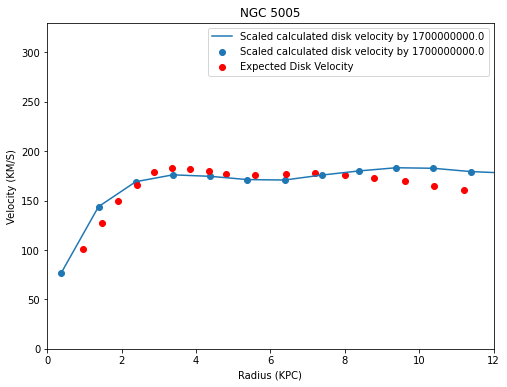

In [22]:
scale = 1.7e9
plt.figure(figsize=(8,6))             
plt.scatter(radii, scale*velocs, linestyle='solid', label='Scaled calculated disk velocity by {}'.format(scale))
plt.plot(radii, scale*velocs, linestyle='solid', label='Scaled calculated disk velocity by {}'.format(scale))
#plt.plot(radii[np.isnan(velocs)==False], scale*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
#plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.scatter(traceddisk_r, traceddisk_v, label='Expected Disk Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
plt.xlim(0,12)
plt.ylim(0,330)
plt.legend(fontsize=10)
plt.show()

In [23]:
print(radii)
print(velocs)

[ 0.38  1.38  2.38  3.38  4.38  5.38  6.38  7.38  8.38  9.38 10.38 11.38
 12.38 13.38 14.38 15.38 16.38 17.38 18.38 19.38 20.38 21.38 22.38 23.38
 24.38 25.38 26.38 27.38 28.38 29.38 30.38 31.38 32.38 33.38 34.38 35.38
 36.38]
[4.52574631e-08 8.46014927e-08 9.94541774e-08 1.03533123e-07
 1.02659198e-07 1.00711871e-07 1.00447117e-07 1.03390792e-07
 1.05854896e-07 1.07755906e-07 1.07441362e-07 1.05478529e-07
 1.04553328e-07 1.04091347e-07 1.03389987e-07 1.02958169e-07
 1.02488030e-07 1.02089717e-07 1.01770344e-07 1.01498208e-07
 1.01242608e-07 1.01013622e-07 1.00808353e-07 1.00622000e-07
 1.00442937e-07 1.00281937e-07 1.00139687e-07 1.00013855e-07
 9.98928427e-08 9.97809674e-08 9.96786284e-08 9.95830616e-08
 9.94922094e-08 9.94064143e-08 9.93279025e-08 9.92536493e-08
 9.91796128e-08]


In [24]:
print(traceddisk_r)

[ 0.975   1.4655  1.9139  2.4041  2.8662  3.3563  3.8321  4.3498  4.8117
  5.5954  6.4072  7.205   8.0167  8.7864  9.612  10.3957 11.1934]
